In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import pickle

# Function Definitions

In [7]:
def jacknife(data,f):
    N = len(data)
    err = 0
    bias = 0
    data_f = f(data)
    for i in range(N):
        d = data.pop(i)
        omit_f = f(data)
        err = np.add(err, (N-1)/N*np.subtract(data_f,omit_f)**2)
        bias = np.add(bias,np.divide(omit_f,N))
        data.insert(i, d)
    err = np.power(err,0.5)
    return [np.add(data_f,np.multiply(N-1,np.subtract(data_f,bias))), err]

def jacknife2(data1,data2,f):
    N = len(data1)
    err = 0
    bias = 0
    data_f = f(data1,data2)
    for i in range(N):
        d1 = data1.pop(i)
        d2 = data2.pop(i)
        omit_f = f(data1,data2)
        err = np.add(err, (N-1)/N*np.subtract(data_f,omit_f)**2)
        bias = np.add(bias,np.divide(omit_f,N))
        data1.insert(i, d1)
        data2.insert(i, d2)
    err = np.power(err,0.5)
    return [np.add(data_f,np.multiply(N-1,np.subtract(data_f,bias))), err]

def get_obs_avg(data, cutoff=0, corr_dist=1):
    avg = np.mean([data[i] for i in range(cutoff, len(data), corr_dist)])
    err = np.std([data[i] for i in range(cutoff, len(data), corr_dist)])/((len(data)-cutoff)/corr_dist)**0.5
    return [avg, err]

def get_obs_avg_jacknife(data, cutoff=0, corr_dist=1):
    return jacknife([data[i] for i in range(cutoff, len(data), corr_dist)], np.mean)

def get_correlator_avgs(corrs, cutoff=0, corr_dist=1):
    avgs = [np.mean([corrs[i][j] for i in range(cutoff,len(corrs),corr_dist)]) for j in range(len(corrs[0]))]
    errs = [np.std([corrs[i][j] for i in range(cutoff,len(corrs),corr_dist)])/((len(corrs)-cutoff)/corr_dist)**0.5 for j in range(len(corrs[0]))]
    # Because of periodic boundary conditions, the last correlator should be equal to the first
    avgs.append(avgs[0])
    errs.append(errs[0])
    return [avgs, errs]

def get_correlator_avgs_jacknife(corrs, cutoff=0, corr_dist=1):
    avgs = []
    errs = []
    for i in range(len(corrs[0])):
        a, b = jacknife([corrs[j][i] for j in range(cutoff, len(corrs), corr_dist)], np.mean)
        avgs.append(a)
        errs.append(b)
    # Because of periodic boundary conditions, the last correlator should be equal to the first
    avgs.append(avgs[0])
    errs.append(errs[0])
    return [avgs, errs]

cosh_model = lambda nt,A0,m_pi : [A0*np.cosh((Nt/2.0-nt[i])*m_pi) for i in range(len(nt))]

def find_mass_from_fit(corr_avgs, fit_range_start, mass_guess=0.3):
    Nt = len(corr_avgs) - 1
    nt = range(fit_range_start,int(Nt)+1-fit_range_start)
    A0_guess = .1#np.abs(corr_avgs[int(Nt/2)])
    a = corr_avgs[fit_range_start:int(Nt)+1-fit_range_start]
    pi_opt, pi_cov = curve_fit(cosh_model, nt, corr_avgs[fit_range_start:int(Nt)+1-fit_range_start], 
                               p0=[A0_guess,mass_guess])
    return [np.abs(pi_opt[1]), pi_opt[0]]

def mass_jacknife(data, m0):
    pcorr_avgs = [np.mean([data[i][j] for i in range(len(data))]) for j in range(len(data[0]))]
    pcorr_errs = [np.std([data[i][j] for i in range(len(data))])/len(data)**0.5 for j in range(len(data[0]))]
    return find_mass_from_fit(pcorr_avgs, 0, mass_guess=m0)

def autocorr(data):
    N = len(data)
    mean = np.mean(data)
    variance = np.var(data)
    data = np.subtract(data,mean)
    r = np.correlate(data, data, mode = 'full')[-N:]
    assert np.allclose(r, np.array([np.sum(np.multiply(data[:N-k],data[-(N-k):])) for k in range(N)]))
    result = r/(variance*(np.arange(N, 0, -1)))
    return result

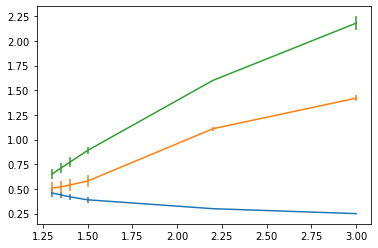

In [8]:
m = [1.3, 1.35, 1.4, 1.5, 2.2, 3.0]
mpi = [.46, 0.44, .42, .39, .30, .25]
mpie = [.04, .03, .03, .03, .004, .003]
fpi = [.65, .71, .77, .89, 1.60, 2.18]
fpie = [.05, .05, .05, .04, .008, 0.07]
ms = [0.51, .52, .54, .58, 1.11, 1.42]
mse = [0.06, .06, .06, .06, .02, 0.03]

plt.errorbar(m, mpi, yerr=mpie)
plt.errorbar(m, ms, yerr=mse)
plt.errorbar(m, fpi, yerr=fpie)
plt.show()

# Data Initialization

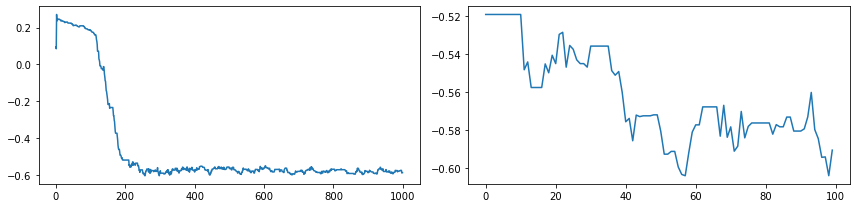

0.5812794151590205


In [41]:
# Extent of the lattice
Nx = 8
Nt = 16
# Spacial volume of the lattice
Vx = Nx**3
# The parameters in the action
m_sq = -.5*4**3
lmbd = 2.*4**3
alpha = 0.1#*2.0**0.5

date = "2022-09"
day = "07"

# The number of trajectories until thermalization
cutoff = 200
# The correlation distance of the trajectories
corr_dist = 5

# Load the data
with open(f"sigma_pion_corrs_{Nx}x{Nt}_msq_{m_sq}_lmbd_{lmbd}_alph_{alpha}_{date}-{day}.bin","rb") as input:
#    [psq_list,phi_list,timeslices,A_timeslices]=pickle.load(input)
#    [accept_rates,psq_list,phi_list,timeslices,A_timeslices,psq_pred_list,phi_pred_list,timeslices_pred,A_timeslices_pred,fields,momentums,fields_pred]=pickle.load(input)
#    [accept_rates,psq_list,phi_list,sp_timeslices,timeslices,A_timeslices,psq_pred_list,phi_pred_list,sp_timeslices_pred,timeslices_pred,A_timeslices_pred,fields,momentums,fields_pred]=pickle.load(input)
#    [accept_rates,psq_list,phi_list,sp_timeslices,dL_timeslices,timeslices,A_timeslices,psq_pred_list,phi_pred_list,sp_timeslices_pred,dL_timeslices_pred,timeslices_pred,A_timeslices_pred,fields,momentums,fields_pred]=pickle.load(input)
#    [varibles,accept_rates,psq_list,phi_list,timeslices,hm_timeslices,A_timeslices,phi_sq_dist,phi_i_dist,theta_dist,psq_pred_list,phi_pred_list,timeslices_pred,hm_timeslices_pred,A_timeslices_pred,fields,momentums,fields_pred]=pickle.load(input)
    data = pickle.load(input)
[accept_rates,psq_list,phi_list,timeslices,hm_timeslices,A_timeslices,phi_sq_dist,phi_i_dist,theta_dist,psq_pred_list,phi_pred_list,timeslices_pred,hm_timeslices_pred,A_timeslices_pred,fields,momentums,fields_pred] = [data["accept_rates"],data["psq_list"],data["phi_list"],data["timeslices"],data["hm_timeslices"],data["ax_cur_timeslices"],data["phi_sq_dist"],data["phi_i_dist"],data["theta_dist"],data["psq_pred_list"],data["phi_pred_list"],data["timeslices_pred"],data["hm_timeslices_pred"],data["ax_cur_timeslices_pred"],data["fields"],data["momentums"] ,data["field_pred"]]

# Plot an observable
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
axes[0].plot([phi_list[i][0] for i in range(0,len(psq_list))])
axes[1].plot([phi_list[i][0] for i in range(cutoff,cutoff+100)])

plt.tight_layout()
plt.show()

print(np.mean(accept_rates[cutoff:]))

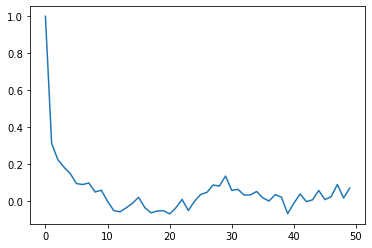

In [42]:
# Plot the autocorrelation of <phi^2>
ac = autocorr(psq_list[cutoff:])
plt.plot(ac[:50])

# Vacuum Expectation Values

In [43]:
end=len(phi_list)
vev_phi0, vev_phi0_err = get_obs_avg_jacknife([phi_list[i][0] for i in range(end)], cutoff, corr_dist)
vev_phi0_pred, vev_phi0_pred_err = get_obs_avg_jacknife([phi_pred_list[i][0] for i in range(len(phi_list))], cutoff, corr_dist)
print(f"Vacuum Expectation Value of phi_0           = {vev_phi0} +- {vev_phi0_err}")
print(f"Predicted Vacuum Expectation Value of phi_0 = {vev_phi0_pred} +- {vev_phi0_pred_err}")

vev_sigma, vev_sigma_err = get_obs_avg_jacknife([np.sum([timeslices[i][t][0] for t in range(Nt)])/Nt/Vx for i in range(len(timeslices))], cutoff, corr_dist)
vev_sigma_pred, vev_sigma_pred_err = get_obs_avg_jacknife([np.sum([timeslices_pred[i][t][0] for t in range(Nt)])/Nt/Vx for i in range(len(timeslices_pred))], cutoff, corr_dist)
print(f"Vacuum Expectation Value of Sigma           = {vev_sigma} +- {vev_sigma_err}")
print(f"Predicted Vacuum Expectation Value of Sigma = {vev_sigma_pred} +- {vev_sigma_pred_err}")

Vacuum Expectation Value of phi_0           = -0.5747164474271917 +- 0.0011303447071464917
Predicted Vacuum Expectation Value of phi_0 = -0.5322742877567843 +- 0.009352411324009347
Vacuum Expectation Value of Sigma           = -0.5747164474271917 +- 0.001130344707146491
Predicted Vacuum Expectation Value of Sigma = -0.5322742877568021 +- 0.009352411324009302


In [44]:
vev_phii, vev_phii_err = get_obs_avg_jacknife([np.mean([phi_list[i][1],phi_list[i][2],phi_list[i][3]]) for i in range(len(phi_list))], cutoff, corr_dist)
vev_pi, vev_pi_err = get_obs_avg_jacknife([np.sum([np.sum([timeslices[i][t][j] for j in [1,2,3]]) for t in range(Nt)])/Nt/Vx for i in range(len(timeslices))], cutoff, corr_dist)
print(f"Vacuum Expectation Value of phi_i = {vev_phii} +- {vev_phii_err}")
print(f"Vacuum Expectation Value of pi = {vev_pi} +- {vev_pi_err}")

Vacuum Expectation Value of phi_i = 0.015927310517679007 +- 0.0025259412501901805
Vacuum Expectation Value of pi = 0.04778193155303757 +- 0.007577823750570523


In [45]:
vev_phisq, vev_phisq_err = get_obs_avg_jacknife([psq_list[i] for i in range(len(psq_list))], cutoff, corr_dist)
vev_phisq_pred, vev_phisq_pred_err = get_obs_avg_jacknife([psq_pred_list[i] for i in range(len(psq_pred_list))], cutoff, corr_dist)
print(f"Vacuum Expectation Value of phi^2           = {vev_phisq} +- {vev_phisq_err}")
print(f"Predicted Vacuum Expectation Value of phi^2 = {vev_phisq_pred} +- {vev_phisq_pred_err}")

Vacuum Expectation Value of phi^2           = 0.35345708228253536 +- 9.840877653859236e-05
Predicted Vacuum Expectation Value of phi^2 = 0.2081001374251503 +- 0.001581762509490917


# Correlators

In [57]:
def sigma_correlator(tslices,Vx,Nt,vev_sigma,delta_t):
    rtn = 0
    for t0 in range(Nt):
        rtn += (tslices[t0%Nt][0]/Vx-vev_sigma)*(tslices[(t0+delta_t)%Nt][0]/Vx-vev_sigma)
    return rtn/Nt

def pion_correlator(tslices,Vx,Nt,delta_t):
    rtn = 0
    for t0 in range(Nt):
        rtn += (tslices[t0%Nt][1]*tslices[(t0+delta_t)%Nt][1] + 
                tslices[t0%Nt][2]*tslices[(t0+delta_t)%Nt][2] + 
                tslices[t0%Nt][3]*tslices[(t0+delta_t)%Nt][3])/3.0
    return rtn/Nt

end = len(timeslices)
pi_corrs = [[pion_correlator(timeslices[i],Vx,Nt,dt) for dt in range(Nt)] for i in range(cutoff,end,corr_dist)]
s_corrs = [[sigma_correlator(timeslices[i],Vx,Nt,vev_sigma,dt) for dt in range(Nt)] for i in range(cutoff,end,corr_dist)]
pi_corrs_pred = [[pion_correlator(timeslices_pred[i],Vx,Nt,dt) for dt in range(Nt)] for i in range(cutoff,end,corr_dist)]
s_corrs_pred = [[sigma_correlator(timeslices_pred[i],Vx,Nt,vev_sigma_pred,dt) for dt in range(Nt)] for i in range(cutoff,end,corr_dist)]

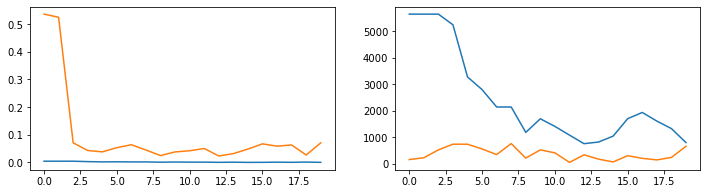

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
axes[0].plot([s_corrs[i][1] for i in range(0,20)])
axes[1].plot([pi_corrs[i][1] for i in range(0,20)])
axes[0].plot([s_corrs_pred[i][1] for i in range(0,20)])
axes[1].plot([pi_corrs_pred[i][1] for i in range(0,20)])

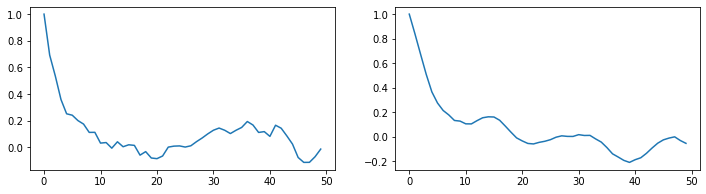

In [60]:
ac_pi = autocorr([pi_corrs[i][0] for i in range(len(pi_corrs))])
ac_s = autocorr([s_corrs[i][0] for i in range(len(s_corrs))])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
axes[0].plot(ac_s[:50])
axes[1].plot(ac_pi[:50])

# Pion Mass

In [61]:
f = lambda data : mass_jacknife(data, 1.0)
[pi_mass, A0], [pi_mass_err, A0_err] = jacknife(pi_corrs, f)
print(f"Pion mass is {pi_mass}a +- {pi_mass_err}a")

Pion mass is 0.2810091009339429a +- 0.0251085442820377a


In [62]:
[pi_mass_pred, A0_pred], [pi_mass_pred_err, A0_pred_err] = jacknife(pi_corrs_pred, f)
print(f"Predicted pion mass is {pi_mass_pred}a +- {pi_mass_pred_err}a")

Predicted pion mass is 0.3606631562593108a +- 0.057389371924750084a


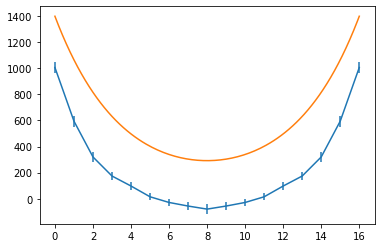

In [63]:
pi_corr_pred_avgs, pi_corr_pred_errs = get_correlator_avgs_jacknife(pi_corrs_pred)

plt_start = 0
plt_end = len(pi_corr_avgs) - plt_start
plt.errorbar(range(plt_start,plt_end), pi_corr_avgs[plt_start:plt_end], yerr=pi_corr_errs[plt_start:plt_end])
#plt.errorbar(range(plt_start,plt_end), pi_corr_pred_avgs[plt_start:plt_end], yerr=pi_corr_pred_errs[plt_start:plt_end])

nt_plt = np.arange(plt_start,plt_end-1+0.1,0.1)
plt.plot(nt_plt, cosh_model(nt_plt, A0, pi_mass))
#plt.plot(nt_plt, cosh_model(nt_plt, A0_pred, pi_mass_pred))

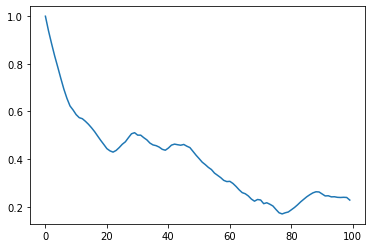

In [64]:
end = len(timeslices)
pi_corrs2 = [[pion_correlator(timeslices[i],Vx,Nt,dt) for dt in range(Nt)] for i in range(max(cutoff,end-500),end)]
masses = []
for i in range(len(pi_corrs2)):
    d=pi_corrs2.pop(i)
    masses.append(mass_jacknife(pi_corrs2, 0.2)[0])
    pi_corrs2.insert(i,d)
ac_masses = autocorr(masses)
plt.plot(ac_masses[:100])

# Sigma Mass

Sigma mass is 0.8499589722013937a +- 0.1238631747306443a


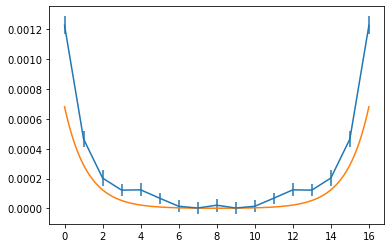

In [65]:
[s_mass, sA0], [s_mass_err, sA0_err] = jacknife(s_corrs, lambda data : mass_jacknife(data, 2.0))
print(f"Sigma mass is {s_mass}a +- {s_mass_err}a")

graph_start=0
s_corr_avgs, s_corr_errs = get_correlator_avgs_jacknife(s_corrs)
plt.errorbar(range(graph_start,len(s_corr_avgs)-graph_start), s_corr_avgs[graph_start:len(s_corr_avgs)-graph_start], 
             yerr=s_corr_errs[graph_start:len(s_corr_avgs)-graph_start])
nt_plt = np.arange(graph_start,len(s_corr_avgs)-1-graph_start+0.1,0.1)
plt.plot(nt_plt, cosh_model(nt_plt, sA0, s_mass))

#[s_mass_pred, sA0_pred], [s_mass_pred_err, sA0_pred_err] = jacknife(s_corrs_pred, lambda data : mass_jacknife(data, 1.0))
#print(f"Predicted sigma mass is {s_mass_pred}a +- {s_mass_pred_err}a")

#s_corr_pred_avgs, s_corr_pred_errs = get_correlator_avgs_jacknife(s_corrs_pred)
#plt.errorbar(range(graph_start,len(s_corr_pred_avgs)-graph_start), s_corr_pred_avgs[graph_start:len(s_corr_pred_avgs)-graph_start], 
#             yerr=s_corr_pred_errs[graph_start:len(s_corr_pred_avgs)-graph_start])
#plt.plot(nt_plt, cosh_model(nt_plt, sA0_pred, s_mass_pred))

Sigma mass is 0.8500811979436735a +- 0.12386333591097376a
1.5139436452328818e-06


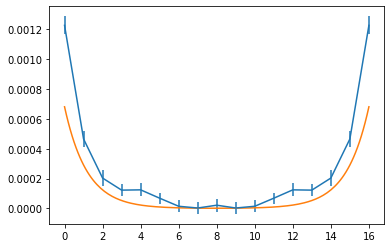

In [66]:
[s_mass, sA0], [s_mass_err, sA0_err] = jacknife(phi0_corrs, lambda data : mass_jacknife(data, 1.0))
print(f"Sigma mass is {s_mass}a +- {s_mass_err}a")

graph_start=0
s_corr_avgs, s_corr_errs = get_correlator_avgs_jacknife(phi0_corrs)
plt.errorbar(range(graph_start,len(s_corr_avgs)-graph_start), s_corr_avgs[graph_start:len(s_corr_avgs)-graph_start], 
             yerr=s_corr_errs[graph_start:len(s_corr_avgs)-graph_start])
nt_plt = np.arange(graph_start,len(s_corr_avgs)-1-graph_start+0.1,0.1)
plt.plot(nt_plt, cosh_model(nt_plt, sA0, s_mass))
print(sA0)

<ErrorbarContainer object of 3 artists>

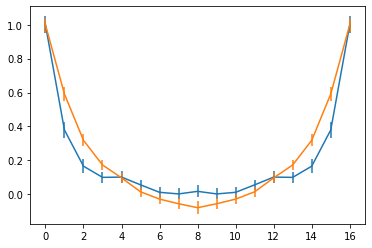

In [67]:
s_corr_avgs, s_corr_errs = get_correlator_avgs_jacknife(s_corrs)
plt.errorbar(range(graph_start,len(s_corr_avgs)-graph_start), s_corr_avgs[graph_start:len(s_corr_avgs)-graph_start]/s_corr_avgs[0], 
             yerr=s_corr_errs[graph_start:len(s_corr_avgs)-graph_start]/s_corr_avgs[0])
plt.errorbar(range(graph_start,len(pi_corr_avgs)-graph_start), pi_corr_avgs[graph_start:len(pi_corr_avgs)-graph_start]/pi_corr_avgs[0], 
             yerr=pi_corr_errs[graph_start:len(pi_corr_avgs)-graph_start]/pi_corr_avgs[0])

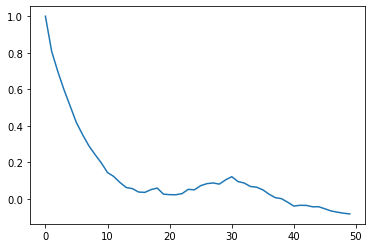

In [68]:
end = len(timeslices)
sigma_corrs2 = [[sigma_correlator(timeslices[i],Vx,Nt,vev_sigma,dt) for dt in range(Nt)] for i in range(max(cutoff,end-500),end)]
s_masses = []
for i in range(len(sigma_corrs2)):
    d=sigma_corrs2.pop(i)
    s_masses.append(mass_jacknife(sigma_corrs2, 1.0)[0])
    sigma_corrs2.insert(i,d)
ac_s_masses = autocorr(s_masses)
plt.plot(ac_s_masses[:50])

# Pion Decay Constant

In the continuum, we can define $F_\pi$ by
$$\langle 0|A_0^i(\mathbf{x},t)|\pi^i(\mathbf{p}=0)\rangle=F_\pi m_\pi e^{-m_\pi t}.$$
On the lattice, this becomes

$$\langle0|A_0^i(\mathbf{x},t)|\pi^i(\mathbf{p}=0)\rangle=F_\pi m_\pi \left(e^{-m_\pi (t-1/2)}+e^{-m_\pi (N_T-t+1/2)}\right)=2F_\pi m_\pi e^{-m_\pi N_T/2}\sinh((N_T/2-t+1/2)m_\pi)$$

(we use $t-1/2$ instead of $t$ because our lattice definition of $A_0^i$ combines fields at $t$ and $t-1$). This then implies (because $\langle 0|A_{1,2,3}^i|\pi^i(\mathbf{p}=0)\rangle=0$) that

$$\langle0|\sum_\mu \big(A_\mu^i(x+\mu)-A_\mu^i(x)\big)|\pi^i(\mathbf{p}=0)\rangle=F_\pi m_\pi \left(e^{-m_\pi (t+1/2)}+e^{-m_\pi (N_T-t-1/2)}-e^{-m_\pi (t-1/2)}-e^{-m_\pi (N_T-t+1/2)}\right)$$
$$=2F_\pi m_\pi e^{-m_\pi N_T/2}\big(\sinh((N_T/2-t-1/2)m_\pi)-\sinh((N_T/2-t+1/2)m_\pi)\big).$$

Now by Noether's theorem for the lattice, $\sum_\mu \big(A_\mu^i(x+\mu)-A_\mu^i(x)\big)=-\alpha\phi^i(x).$ So

$$F_\pi=-\frac{\alpha \langle 0| \phi^i(x)|{\pi^i(\mathbf{p}=0)}\rangle}{2m_\pi e^{-N_Tm_\pi/2}\big(\sinh((N_T/2-t-1/2)m_\pi)-\sinh((N_T/2-t+1/2)m_\pi)\big)}.$$

and we can use

$$|{\pi^i(\mathbf{p}=0)}\rangle=\sqrt{2m_\pi V_x}\frac{\sqrt{2e^{-N_Tm_\pi/2}\cosh((N_T/2-t)m_\pi)}\left(\sum_{\mathbf{x}}\phi_i(\mathbf{x},0)\right)|0\rangle}{\sqrt{\langle0| \left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',t)\right)\left(\sum_{\mathbf{x}''}\phi_i(\mathbf{x}'',0)\right)|0\rangle}}.$$

Finally,
$$F_\pi=-\frac{\alpha \langle 0| \frac{1}{V_x}\sum_\mathbf{x}\phi^i(\mathbf{x},t)|{\pi^i(\mathbf{p}=0)}\rangle}{2m_\pi e^{-N_Tm_\pi/2}\big(\sinh((N_T/2-t-1/2)m_\pi)-\sinh((N_T/2-t+1/2)m_\pi)\big)}$$

$$=-\frac{\alpha\sqrt{2m_\pi V_x \cdot 2e^{-N_Tm_\pi/2}\cosh((N_T/2-t)m_\pi)} \langle 0| \left(\sum_\mathbf{x}\phi^i(\mathbf{x},t)\right)\left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',0)\right)|0\rangle}{2V_x m_\pi e^{-N_Tm_\pi/2}\big(\sinh((N_T/2-t-1/2)m_\pi)-\sinh((N_T/2-t+1/2)m_\pi)\big)\sqrt{\langle0| \left(\sum_{\mathbf{x}}\phi_i(\mathbf{x},t)\right)\left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',0)\right)|0\rangle}}$$

$$=-\frac{\alpha\sqrt{\cosh((N_T/2-t)m_\pi)} \sqrt{\langle 0| \left(\sum_\mathbf{x}\phi^i(\mathbf{x},t)\right)\left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',0)\right)|0\rangle}}{\sqrt{m_\pi V_x} e^{-N_Tm_\pi/4}\big(\sinh((N_T/2-t-1/2)m_\pi)-\sinh((N_T/2-t+1/2)m_\pi)\big)}.$$

F_pi is 1.5940938566548222/a +- 0.22752800438691242/a
m_pi is 0.27360200496679643/a +- 0.02505523720125987/a


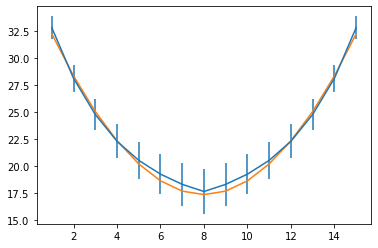

In [72]:
fpi_model2 = lambda nt,A0,m_pi,alpha : [-A0/alpha*(m_pi*Vx*np.exp(-m_pi*Nt/2))**0.5*(np.sinh((Nt/2.0-nt[i]-1/2)*m_pi)-
                                                                                     np.sinh((Nt/2.0-nt[i]+1/2)*m_pi))/
                                        (np.cosh((Nt/2.0-nt[i])*m_pi))**0.5 for i in range(len(nt))]

def fpi_fit2(pi_corr_avgs, fit_range_start, A0_guess=2.0, mpi_guess=0.2):
    Nt = len(pi_corr_avgs) - 1
    nt = range(fit_range_start,int(Nt)+1-fit_range_start)
    a = np.power(pi_corr_avgs[fit_range_start:int(Nt)+1-fit_range_start], 0.5)
    a = np.nan_to_num(a)
    pi_opt, pi_cov = curve_fit(lambda nt,A0,pi_mass : fpi_model2(nt,A0,pi_mass,alpha), nt, 
                               a, p0=[A0_guess, mpi_guess])
    return pi_opt

def fpi_jacknife2(pi_corrs):
    pi_corr_avgs = [np.mean([pi_corrs[i][j] for i in range(len(pi_corrs))]) for j in range(len(pi_corrs[0]))]
    return fpi_fit2(pi_corr_avgs, 0)

[fpi2, mpi2], [fpi2_err, mpi2_err] = jacknife(pi_corrs,fpi_jacknife2)
print(f"F_pi is {fpi2}/a +- {fpi2_err}/a")
print(f"m_pi is {mpi2}/a +- {mpi2_err}/a")

def f(pi_corrs):
    pi_corr_avgs = [np.mean([pi_corrs[i][j] for i in range(len(pi_corrs))]) for j in range(len(pi_corrs[0]))]
    return np.power(pi_corr_avgs[1:int(Nt)], 0.5)
a,b = jacknife(pi_corrs,f)

plt.errorbar(range(1,len(a)+1), a, yerr=b)
plt.plot(range(1,Nt), fpi_model2(range(1,Nt), fpi2, mpi2, alpha))

Predicted F_pi is 0.4749758896105925/a +- 0.08330547499259078/a
Predicted m_pi is 0.3073515451110349/a +- 0.03484765944002642/a


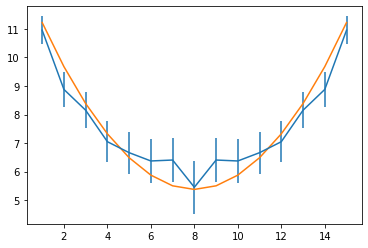

In [74]:
[fpi2_pred, mpi2_pred], [fpi2_pred_err, mpi2_pred_err] = jacknife(pi_corrs_pred,fpi_jacknife2)
print(f"Predicted F_pi is {fpi2_pred}/a +- {fpi2_pred_err}/a")
print(f"Predicted m_pi is {mpi2_pred}/a +- {mpi2_pred_err}/a")

a,b = jacknife(pi_corrs_pred,f)
plt.errorbar(range(1,Nt), a, yerr=b)
plt.plot(range(1,Nt), fpi_model2(range(1,Nt), fpi2_pred, mpi2_pred, alpha))

Alternatively, we can use

$$\langle0|A_0^i(\mathbf{x},t)|\pi^i(\mathbf{p}=0)\rangle=2F_\pi m_\pi e^{-m_\pi N_T/2}\sinh((N_T/2-t+1/2)m_\pi)$$

$$=\sqrt{2m_\pi V_x}\frac{\sqrt{2e^{-N_Tm_\pi/2}\cosh((N_T/2-t')m_\pi)}\langle0|A_0^i(\mathbf{x},t)\left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',0)\right)|0\rangle}{\sqrt{\langle0| \left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',t')\right)\left(\sum_{\mathbf{x}''}\phi_i(\mathbf{x}'',0)\right)|0\rangle}}$$

$$\implies F_\pi = \frac{\langle0|\left(\sum_\mathbf{x}A_0^i(\mathbf{x},t)\right)\left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',0)\right)|0\rangle}{\sqrt{\langle0| \left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',t')\right)\left(\sum_{\mathbf{x}''}\phi_i(\mathbf{x}'',0)\right)|0\rangle}}\frac{\sqrt{\cosh((N_T/2-t')m_\pi)}}{\sqrt{m_\pi V_xe^{-m_\pi N_T/2}}\sinh((N_T/2-t+1/2)m_\pi)}.$$

In [78]:
def axpi_correlator(tslices,Atslices,Vx,Nt,delta_t):
    rtn = 0
    for t0 in range(Nt):
        rtn += (Atslices[(t0+delta_t)%Nt][0]*tslices[t0%Nt][1] + 
                Atslices[(t0+delta_t)%Nt][1]*tslices[t0%Nt][2] + 
                Atslices[(t0+delta_t)%Nt][2]*tslices[t0%Nt][3])/3.0
    return rtn/Nt

A_corrs = [[axpi_correlator(timeslices[i],A_timeslices[i],Vx,Nt,dt) for dt in range(Nt)] for i in range(cutoff,len(timeslices),corr_dist)]
A_corr_avgs, A_corr_errs = get_correlator_avgs_jacknife(A_corrs)
A_corr_avgs.pop(len(A_corr_avgs)-1)
A_corr_errs.pop(len(A_corr_errs)-1)

6.263194304883799

F_pi is 0.653865216920586/a +- 0.04094182945503541/a
m_pi is 0.5356804664999806/a +- 0.060385225892205435/a


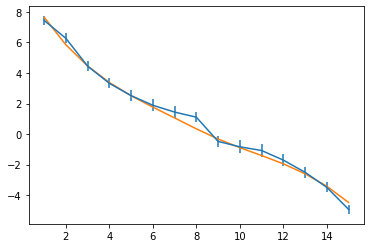

In [79]:
fpi_model = lambda nt,A0,m_pi : [A0*(m_pi*Vx*np.exp(-m_pi*Nt/2))**0.5*np.sinh((Nt/2.0-nt[i]+1/2)*m_pi)/(np.cosh((Nt/2.0-nt[i])*m_pi))**0.5 for i in range(len(nt))]

def fpi_fit(pi_corr_avgs, A_corr_avgs, fit_range_start, A0_guess=2.3, mpi_guess=0.2):
    Nt = len(pi_corr_avgs) - 1
    nt = range(fit_range_start,int(Nt)+1-fit_range_start)
    pi_opt, pi_cov = curve_fit(lambda nt, A0, mpi : fpi_model(nt,A0,mpi), nt, 
                               np.divide(A_corr_avgs[fit_range_start:int(Nt)+1-fit_range_start], 
                                         np.power(pi_corr_avgs[fit_range_start:int(Nt)+1-fit_range_start], 0.5)),
                               p0=[A0_guess, mpi_guess])
    return pi_opt

def fpi_jacknife(pi_corrs, A_corrs):
    A_corr_avgs = [np.mean([A_corrs[i][j] for i in range(len(A_corrs))]) for j in range(len(A_corrs[0]))]
    pi_corr_avgs = [np.mean([pi_corrs[i][j] for i in range(len(pi_corrs))]) for j in range(len(pi_corrs[0]))]
    return fpi_fit(pi_corr_avgs, A_corr_avgs, 1)

[fpi, mpi], [fpi_err, mpi_err] = jacknife2(pi_corrs,A_corrs,fpi_jacknife)
print(f"F_pi is {fpi}/a +- {fpi_err}/a")
print(f"m_pi is {mpi}/a +- {mpi_err}/a")

def f(pi_corrs, A_corrs):
    A_corr_avgs = [np.mean([A_corrs[i][j] for i in range(len(A_corrs))]) for j in range(len(A_corrs[0]))]
    pi_corr_avgs = [np.mean([pi_corrs[i][j] for i in range(len(pi_corrs))]) for j in range(len(pi_corrs[0]))]
    return np.divide(A_corr_avgs[1:int(Nt)], 
                     np.power(pi_corr_avgs[1:int(Nt)], 0.5))
a,b = jacknife2(pi_corrs,A_corrs,f)

plt.errorbar(range(1,Nt), a, yerr=b)
plt.plot(range(1,Nt), fpi_model(range(1,Nt), fpi, mpi))

Since this fit is not very good, we can try eliminating one of the correlation functions. Right now, we have 

$$F_\pi = \frac{\langle0|\left(\sum_\mathbf{x}A_0^i(\mathbf{x},t)\right)\left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',0)\right)|0\rangle}{\sqrt{\langle0| \left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',t')\right)\left(\sum_{\mathbf{x}''}\phi_i(\mathbf{x}'',0)\right)|0\rangle}}\frac{\sqrt{\cosh((N_T/2-t')m_\pi)}}{\sqrt{m_\pi V_xe^{-m_\pi N_T/2}}\sinh((N_T/2-t+1/2)m_\pi)}.$$

Earlier, we found (for the first method)

$$\sqrt{\langle 0| \left(\sum_\mathbf{x}\phi^i(\mathbf{x},t)\right)\left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',0)\right)|0\rangle}=-\frac{F_\pi\sqrt{m_\pi V_x e^{-N_Tm_\pi/2}}\big(\sinh((N_T/2-t-1/2)m_\pi)-\sinh((N_T/2-t+1/2)m_\pi)\big)}{\alpha\sqrt{\cosh((N_T/2-t)m_\pi)}}.$$

Combining these, we get

$$F_\pi^2 = \frac{\alpha {\cosh((N_T/2-t')m_\pi)}\langle0|\left(\sum_\mathbf{x}A_0^i(\mathbf{x},t)\right)\left(\sum_{\mathbf{x}'}\phi_i(\mathbf{x}',0)\right)|0\rangle}{ m_\pi V_xe^{-m_\pi N_T/2}\sinh((N_T/2-t+1/2)m_\pi)\big(\sinh((N_T/2-t-1/2)m_\pi)-\sinh((N_T/2-t+1/2)m_\pi)\big)}.$$

m_pi is 0.40584586912196036/a +- 0.027886956644164556/a
F_pi is 0.8422965783094107/a +- 0.04840192539057754/a


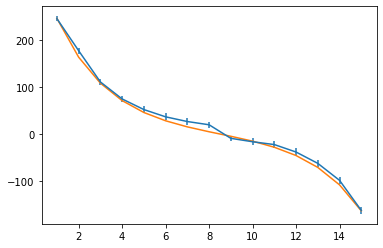

In [80]:
fpi_model = lambda nt,f_pi,m_pi : [-f_pi**2*m_pi*Vx*np.exp(-m_pi*Nt/2)*np.sinh((Nt/2-nt[i]+1/2)*m_pi)*(np.sinh((Nt/2-nt[i]-1/2)*m_pi)-np.sinh((Nt/2-nt[i]+0.5)*m_pi))/(alpha*np.cosh((Nt/2-nt[i])*m_pi)) for i in range(len(nt))]

def fpi_fit(A_corr_avgs, fit_range_start, fpi_guess=2.3, mpi_guess=0.2):
    Nt = len(pi_corr_avgs) - 1
    nt = range(fit_range_start,int(Nt)+1-fit_range_start)
    pi_opt, pi_cov = curve_fit(lambda nt, fpi, mpi : fpi_model(nt,fpi,mpi), nt, 
                               A_corr_avgs[fit_range_start:int(Nt)+1-fit_range_start],
                               p0=[fpi_guess, mpi_guess])
    return pi_opt

def fpi_jacknife(A_corrs):
    A_corr_avgs = [np.mean([A_corrs[i][j] for i in range(len(A_corrs))]) for j in range(len(A_corrs[0]))]
    return fpi_fit(A_corr_avgs, 1)

[fpi, mpi], [fpi_err, mpi_err] = jacknife(A_corrs,fpi_jacknife)
print(f"m_pi is {mpi}/a +- {mpi_err}/a")
print(f"F_pi is {fpi}/a +- {fpi_err}/a")

def f(A_corrs):
    A_corr_avgs = [np.mean([A_corrs[i][j] for i in range(len(A_corrs))]) for j in range(len(A_corrs[0]))]
    return A_corr_avgs[1:int(Nt)]
a,b = jacknife(A_corrs,f)

plt.errorbar(range(1,Nt), a, yerr=b)
plt.plot(range(1,Nt), fpi_model(range(1,Nt), fpi, mpi))